# Rice Classification with NN and PCA (using CUDA)


dataset contains 75000 images from 5 diffrent type of rices :

1. Arborio
2. Basmati
3. Ipsala
4. Jasmine
5. Karacadag

15000 images for each class of rice

dataset : https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

using cuda in this case will use 2x memory because tensors in cuda should be copied to cpu in order to change to numpy

### choosing device

In [1]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


### creating dataset class


In [2]:
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
from math import floor
from torchvision.transforms import Grayscale,Resize


labelsDict = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"
}

class Custom_Dataset(Dataset):
    def __init__(self,labels ,img_dir,transform=None):
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # label = labelsDict[floor(idx/15000)]
        label = self.labels[idx]
        label = label.to(device)
        img_name = labelsDict[int(label)]+" (" + str(idx -(15000*floor(idx/15000))+1) +").jpg"
        img_path = os.path.join(os.getcwd(),self.img_dir, img_name)
        image = read_image(img_path)
        # label = int(label.item())
        image = Grayscale()(image) #remove 3 image channels
        image = Resize(size=(50,50),antialias=True)(image)
        image = image.squeeze()
        image = image.float()
        image = image.to(device)
        if(self.transform):
            image = self.transform(image)
        return image, label
    


### creating our dataset

In [3]:
labels = torch.zeros(75000)
labels[15000:30000] = 1
labels[30000:45000] = 2
labels[45000:60000] = 3
labels[60000:75000] = 4

dataset = Custom_Dataset(labels,"Rice_Image_Dataset")

### shuffeling and creating train / test dataset

In [4]:
import numpy as np

N = len(dataset)

indices = np.arange(N)
indices = np.random.permutation(indices)

slice = int(0.8*N)

train_indices = indices[:slice]
test_indices = indices[slice:]


### Loading Data (for PCA)

In [5]:
from torch.utils.data import Subset

train_dataset = Subset(dataset,train_indices)
test_dataset = Subset(dataset,test_indices)


### train PCA

moving test dataset to numpy for using sklearn pca

In [6]:
X_train = np.array([train_dataset[i][0].cpu().numpy().flatten() for i in range(len(train_dataset))])

plotting first data

(60000, 2500)


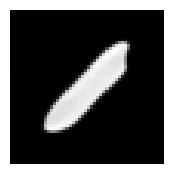

In [7]:
import matplotlib.pyplot as plt

print(X_train.shape)

plt.figure(figsize=(2,2))
plt.imshow(X_train[0].reshape(50,50),cmap="gray")
plt.axis("off")
plt.show()


fitting pca

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_train_scaled = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=250,whiten=True).fit(X_train_scaled)


testing pca on first data

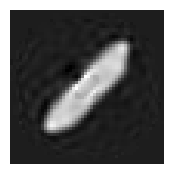

In [9]:
test = pca.transform([X_train[0]])
test = pca.inverse_transform(test)[0].reshape(50,50)
plt.figure(figsize=(2,2))
plt.imshow(test,cmap="gray")
plt.axis("off")
plt.show()

first five pca components

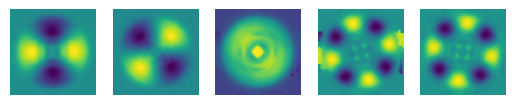

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(pca.components_[i].reshape(50,50))
    ax[i].axis("off")


creating a custom transformation func to use with dataset

In [16]:
def customTransform(x):
    # x is a 50x50 tensor
    x_pca = pca.transform([x.cpu().numpy().flatten()])[0]
    return torch.from_numpy(x_pca).float().to(device)

### recreating dataset

In [17]:
dataset = Custom_Dataset(labels,"Rice_Image_Dataset",transform=customTransform)

train_dataset = Subset(dataset,train_indices)
test_dataset = Subset(dataset,test_indices)

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=True)

### creating model

In [21]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(250,512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,5)
        ) 
        
    def forward(self,X):
        logits = self.seq(X)
        return logits

### learning

In [24]:
model = NeuralNetwork().to(device)

learning_rate = 1e-2
epoches = 4
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

def train_loop(train_dataloader,model,loss_fn,optim):
    model.train()
    for batch, (X,y) in enumerate(train_dataloader):
        y=y.to(torch.int64)
        pred = model(X)
        loss = loss_fn(pred,y)

        loss.backward()
        optim.step()
        optim.zero_grad()

        if (batch % 100 == 0):
            loss = loss.item()
            current = (batch+1)*len(X)
            total_size = len(train_dataloader.dataset)
            print("loss : {} / [{}/{}]".format(loss,current,total_size))

def test_loop(test_dataloader,model,loss_fn):
    model.eval()
    test_loss,correct = 0,0

    with torch.no_grad():
        for X,y in test_dataloader:
            y=y.to(torch.int64)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    correct /= size # acuuracy
    test_loss /= num_batches # avg loss in each batch

    print("Test ERR >> Acc : {} / Avg Loss : {}".format(correct,test_loss))
    return correct

finalAcc = -100

for i in range(epoches):
    print("EPOCH {} -----------------------------".format(i+1))
    train_loop(train_dataloader,model,loss_fn,optimizer)
    acc = test_loop(test_dataloader,model,loss_fn)
    finalAcc = acc

print("Done, Accuracy is : {}".format(finalAcc))


EPOCH 1 -----------------------------
loss : 4.791212558746338 / [64/60000]
loss : 0.273099809885025 / [6464/60000]
loss : 0.27644699811935425 / [12864/60000]
loss : 0.08624141663312912 / [19264/60000]
loss : 0.2240728735923767 / [25664/60000]
loss : 0.08925768733024597 / [32064/60000]
loss : 0.07239732891321182 / [38464/60000]
loss : 0.18670770525932312 / [44864/60000]
loss : 0.13838478922843933 / [51264/60000]
loss : 0.15778855979442596 / [57664/60000]
Test ERR >> Acc : 0.973 / Avg Loss : 0.08484698775759403
EPOCH 2 -----------------------------
loss : 0.07177840173244476 / [64/60000]
loss : 0.025561591610312462 / [6464/60000]
loss : 0.049971822649240494 / [12864/60000]
loss : 0.08598895370960236 / [19264/60000]
loss : 0.04940491542220116 / [25664/60000]
loss : 0.08135995268821716 / [32064/60000]
loss : 0.04285848140716553 / [38464/60000]
loss : 0.08050642162561417 / [44864/60000]
loss : 0.2819751799106598 / [51264/60000]
loss : 0.0339844711124897 / [57664/60000]
Test ERR >> Acc : 0.

after around **18m**(using cuda) resulted with accuracy **98%**<br>